# 9.6 Lab: Support Vector Machines

## 9.6.1 Support Vector Classifier

Demonstrate the support vector classifier (SVC) and the support vector machine (SVM). This first lab looks at the Support Vector Classifier with a `kernel = "linear"`. A `C` (cost) hyperparameter allows us to specify the cost of a violation to the margin. Then the cost is small, the margin will be wide, and when the cost is large, the margin will be narrow. 

The scikit-learn library contains implementations for [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html) (SVM) in the `sklearn.svm` namespace. 


In [1]:
import numpy
import pandas 

import sklearn
import sklearn.svm
import sklearn.pipeline

import matplotlib
import matplotlib.pyplot as pyplot 

from collections import Counter

## NumPy Background on Random Seeds and Matrix

### NumPy Random Seeds 

We will be using random samplying through NumPy, and to ensure that we receive the same results everytime we run the notebook, we will be setting a random seed. 

NumPy supports a global instance of the random seed and the ability to make a local instance of the random state. 

### NumPy Matrix and ndarray

The lab examples uses R matrix objects, but while NumPy has a `matrix` object, we don't use that one. We use 2-dimensional NumPy `ndarray` objects. The default data type for array values is `float`, but this can be changed with `dtype` parameter (e.g. `object` for strings).



In [2]:
matrixDimensions: tuple = (2, 2) # shape of the matrix we want to creete

# examples of create a matrix 
# default has a "dtype" of "float"
print ("empty matrix")
print (numpy.empty (shape = matrixDimensions)) # Create an array, but leave its allocated memory unchanged (i.e., it contains “garbage”).
print ("matrix of 1s")
print (numpy.ones (shape = matrixDimensions))
print ("matrix of 0s")
print (numpy.zeros (shape = matrixDimensions)) # Create an array, each element of which is zero.

empty matrix
[[1. 1.]
 [1. 0.]]
matrix of 1s
[[1. 1.]
 [1. 1.]]
matrix of 0s
[[0. 0.]
 [0. 0.]]


In [3]:
# making a matrix manually

designMatrix = [
    [1, 1, 0, 0],  # first row
    [1, 0, 1, 0],  # second row
    [1, 0, 0, 1],  # third row
    [1, 0, 0, 0]   # fourth row

]

numpy.asarray (designMatrix)

array([[1, 1, 0, 0],
       [1, 0, 1, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 0]])

### other useful array functions 

```
numpy.concatenate ([array1, array2, array3]) # 1d array 
numpy.concatenate ((array1, array2), axis = 0) # axis = 0 for by rows, 1 by columns
numpy.append (array1, array2) # 1d array 
numpy.append (array1, array2, axis = 0) # axis = 0 for by rows, 1 by columns
numpy.hstack
numpy.vstack
```

## Support Functions 
These are functions that have been refactored into methods because they were used multiple times throughout the code. These are not meant as robust methods that can be used in general form. 

In [4]:
def Svc2dPlot (x1: numpy.ndarray, x2: numpy.ndarray, y: numpy.ndarray, svmfit: sklearn.svm.SVC, xlim: tuple = None, ylim: tuple = None, showPlot: bool = True):
    """
    Method to plot the 2 dimensional space X2 vs X1 in a scatterplot and 
    overly the decision boundary and support vectors. 

    Parameters
    ----------
    x1: numpy.ndarray (1d)
        x-axis values
    x2: numpy.ndarray (1d)
        y-axis values 
    y: numpy.ndarray (1d)
        the true classification label
    svmfit: sklearn.svm.SVC
        the fitted support vector classifier 

    Returns
    -------
    matplotlib.axes.Axes
    """

    # The below code was modified from:
    # https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
        
    # plot the original points and create a referencable plot axes 
    pyplot.scatter (x = x1, y = x2, c = y, s = 30, cmap = pyplot.cm.Paired)

    # plot the decision function
    axes: matplotlib.axes.Axes = pyplot.gca () # GCA: Get Current Axis (from scatter plot)
    if (xlim is None): 
        xlim: tuple = axes.get_xlim() # get min, max of X axis

    if (ylim is None):
        ylim: tuple = axes.get_ylim() # get min, max of Y axis

    # create grid to evaluate model
    # linspace: Generate linear spaced vector.
    # <function numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)>
    xx: numpy.ndarray = numpy.linspace(xlim[0], xlim[1], 30)
    yy: numpy.ndarray = numpy.linspace(ylim[0], ylim[1], 30)
    # meshgrid: Make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D grids
    YY, XX = numpy.meshgrid(yy, xx)
    xy: numpy.ndarray = numpy.vstack([XX.ravel(), YY.ravel()]).T
    # decision_function: Evaluates the decision function for the samples in X.
    Z:  numpy.ndarray = svmfit.decision_function(X = xy).reshape(XX.shape)

    # plot decision boundary and margins
    axes.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # plot support vectors
    axes.scatter(svmfit.support_vectors_[:, 0], svmfit.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

    # show the plot
    if (showPlot): 
        pyplot.show()   

    return axes

In [5]:
def SvcSummary (svmfit: sklearn.svm.SVC, x: numpy.ndarray, y: numpy.ndarray): 
    """
    Print summary information of the fitted SVC estimator.
    """

    print ("Call:")
    print (svmfit)
    print ("Parameters: ")
    print ("   SVM-Type: C-classification")
    print (" SVM-Kernal: " + svmfit.kernel)
    print ("       cost: " + str (svmfit.C))
    print ("      gamma: " + str (svmfit.gamma))
    print ("Number of Support Vectors:  " + str (len (svmfit.support_)))
    print (Counter (y [svmfit.support_]))
    print ("Number of Classes:  " + str (len (svmfit.classes_)))
    print ("Levels:")
    print (svmfit.classes_)
    print ("Score:")
    print (svmfit.score (x, y))

    return

## Support Vector Classifer Begin

In R, we use the `e1071` package for the `svm ()` function. Below we generate 40 random numbers from a normal distribution in the form of a 2x2 matrix. 

In Python, we will do the same approach using the `numpy.random.normal` (equivalent to `rnorm`) to generate a sample of random values. After demonstrating the random sampling, I have copied over the values that R would produce (given that the seed is set to 1) so that the results will match between environments. 


R Code 
```{R}
install.packages ("e1071")
library ("e1071")
set.seed (1)
x = matrix (rnorm (20 * 2), ncol = 2)
y = c (rep (-1, 10), rep (1, 10))
x [y == 1, ] = x [y == 1, ] + 1
plot (x, col=(3 - y))
```


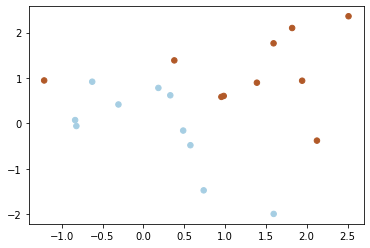

In [6]:
# initialize the global seed for numpy.random so that we can draw the
# same results every time. This will not match the numbers pulled by R.
# this seed was chosen to be close to the same distribution as in R 
# in that the points are not meant to be linearly separable, but the 
# original has better seperation that might not violate the margins.
numpy.random.seed (9)

# first create a 1d array of 40 samples from a normal distribution 
x = numpy.asarray (numpy.random.normal (loc = 0, scale = 1, size = (20 * 2)))

# reshape the 1d array into a 2d array filling by columns then rows 
x = numpy.reshape (x, (20, 2))

# another way to create the matrix by specifying the shape within the random
x = numpy.random.normal (loc = 0, scale = 1, size = (20, 2))

# finally, let's manually create the data set using the values chosen by R
# so that it matches the one generated by the book. 
x = numpy.reshape (numpy.asarray ([
        -0.62645381,  0.91897737,  0.18364332,  0.78213630, -0.83562861,  0.07456498,   1.59528080, -1.98935170,  0.32950777,  0.61982575, 
        -0.82046838, -0.05612874,  0.48742905, -0.15579551,  0.73832471, -1.47075238,   0.57578135, -0.47815006, -0.30538839,  0.41794156,
         1.51178117,  1.35867955,  0.38984324, -0.10278773, -0.62124058,  0.38767161,  -2.21469989, -0.05380504,  1.12493092, -1.37705956,
        -0.04493361, -0.41499456, -0.01619026, -0.39428995,  0.94383621, -0.05931340,   0.82122120,  1.10002537,  0.59390132,  0.76317575
         ]), (20, 2))

# create y response variable of 10 -1 and 10 1 entries
y = numpy.repeat (numpy.array ([-1, 1]), [10, 10])

# increment the x values by 1 for those that have y = 1 at the same row index
# we need to use numpy.where to get the row indices to slice, we expect 
# the first 10 rows to not be modified and the last 10 rows to be modified
x [numpy.where (y == 1)] = x [numpy.where (y == 1)] + 1

# plot the distribution
pyplot.scatter (x = x [:,0], y = x [:, 1], c = y, s = 30, cmap = pyplot.cm.Paired)


R Code 
```
dat = data.frame (x = x, y = as.factor (y))
svmfit = svm (y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE)
```

The argument `scale = FALSE` tells the `svm()` function not to scale each feature to have mean zero or standard deviation one; depending on the application, one might prefer to use `scale = TRUE`. In Python with the scikit-learn implementation, there is not a `scale` parameter on the class initialization. You would need to scale the data in  preprocessing before passing it `fit` method using one of the scalers like `StandardScaler`. Our data is from a normal distribution and does not need further scaling.

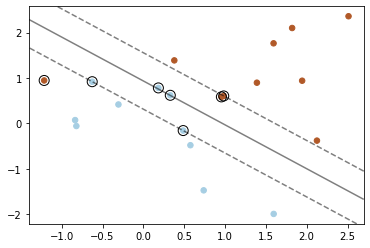

In [7]:
# in sklearn library, SVC, NuSVC and LinearSVC are classes capable of performing binary 
# and multi-class classification on a dataset.
# SVC is the main classifier, NuSVC allows for the nu tuning parameter for an upper bound
# on the fraction of margin errors and a lower bound for the fraction of support vectors, 
# LinearSVC is another implementation of SVC with kernel = "linear".

# The default kernel is the radial basis function (rbf) kernel, we want to use the linear.
# There is no scale option, and if we wanted to scale, we would need to preprocess the data
# before it is passed into the SVC. Also, x and y are separate input parameters and not 
# expected to be in a data frame form.
svmfit = sklearn.svm.SVC (C = 10, kernel="linear") # initialize a model with parameters
svmfit.fit (x, y) # fit the model to the data
Svc2dPlot (x [:, 0], x[:, 1], y, svmfit)


In [8]:
print ("Support Vectors")
print (svmfit.support_vectors_)
print ("\n")

print ("Support Vector Indexes comparing R to Python")
# R values expected
print ("[1, 2, 5, 7, 14, 16, 17]")
# actual, increment the indexes to match 
[index + 1 for index in svmfit.support_]

Support Vectors
[[-0.62645381  0.91897737]
 [ 0.18364332  0.7821363 ]
 [ 0.32950777  0.61982575]
 [ 0.48742905 -0.15579551]
 [-1.21469989  0.94619496]
 [ 0.95506639  0.58500544]
 [ 0.98380974  0.60571005]]


Support Vector Indexes comparing R to Python
[1, 2, 5, 7, 14, 16, 17]


[1, 2, 5, 7, 14, 16, 17]

In [9]:
# print the summary information of the fit 
SvcSummary (svmfit, x, y)

Call:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Parameters: 
   SVM-Type: C-classification
 SVM-Kernal: linear
       cost: 10
      gamma: scale
Number of Support Vectors:  7
Counter({-1: 4, 1: 3})
Number of Classes:  2
Levels:
[-1  1]
Score:
0.85


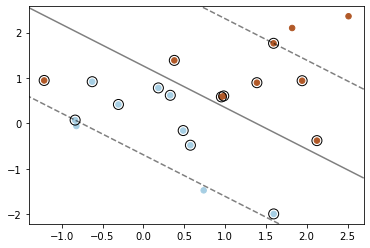

In [10]:
# refit with a smaller value of the cost parameter 
svmfit = sklearn.svm.SVC (C = 0.1, kernel="linear") # initialize a model with parameters
svmfit.fit (x, y) # fit the model to the data
Svc2dPlot (x [:, 0], x[:, 1], y, svmfit)

In [11]:
print ("Support Vector Indexes comparing R to Python")

# R values expected
print ("[1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20]")
# actual, increment the indexes to match 
[index + 1 for index in svmfit.support_]

Support Vector Indexes comparing R to Python
[1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20]


[1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20]

The `e1071` library has a method, `tune`, for perform cross-validation and hyperparameter tuning. By default, it performs a 10-fold cross-validation. 

In Python, we use the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class in the `sklearn.model_selection` namespace to perform hyperparameter tuning. In addition, we can setup a pipeline that might have more steps (like scaling the values before the SVC). The below code sets up a search grid of hyperparameters similar to the R code with the same range of cost values to try. 

R Code
```{R}
tune.out = tune (svm, y ~ ., data = dat, kernel = "linear", ranges = list (cost = c (0.001, 0.01, 0.1, 1, 5, 10, 100)))
summary (tune.out)
bestmod = tune.out$best.model
summary (bestmod)
```

In [12]:
# hyperparameter tunning of the cost for best fit 
# setup a pipeline with the grid search
hyperparameters = { "SVM__C": [0.001, 0.01, 0.1, 1, 5, 10, 100] } # multiple parameters can be added here
pipelineSteps = [("SVM", sklearn.svm.SVC (kernel="linear"))]

# define an instance of the pipeline class 
pipeline = sklearn.pipeline.Pipeline (pipelineSteps)

# setup grid search of hyperparameters with cross validation k-fold = 10
gridSearch = sklearn.model_selection.GridSearchCV (pipeline, param_grid = hyperparameters, cv = 10)

# fit the data to the model
gridSearch.fit (x, y)


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('SVM',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='linear', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'SVM__C': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [13]:
# print summary information of the grid search hyperparameter tuning
print ("Parameter tuning of '" + gridSearch.get_params () ["estimator__steps"][0][0] + "'")
print ("- sampling method: " + str (gridSearch.get_params () ["cv"]) + "-fold cross validation")
print ("- best parameters:")
print (gridSearch.best_params_)
print ("- best performance")
print (gridSearch.best_score_)
print ("cross validation results (mean test score)")
print (gridSearch.cv_results_ ["mean_test_score"])


Parameter tuning of 'SVM'
- sampling method: 10-fold cross validation
- best parameters:
{'SVM__C': 0.1}
- best performance
0.95
cross validation results (mean test score)
[0.75 0.75 0.95 0.9  0.85 0.85 0.85]


In [14]:
# We need to pull the SVC out of the pipeline as best_estimator_ 
# will give us the pipeline object. # bestmod = gridSearch.best_estimator_
name, bestmod = gridSearch.best_estimator_.steps [0]

# print the summary information of the fit 
SvcSummary (bestmod, x, y)

Call:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Parameters: 
   SVM-Type: C-classification
 SVM-Kernal: linear
       cost: 0.1
      gamma: scale
Number of Support Vectors:  16
Counter({-1: 8, 1: 8})
Number of Classes:  2
Levels:
[-1  1]
Score:
0.95


The best model has a cost of 0.1. 

We can predict the classification of new values using the fitted model. Below we create a new test set of data using the same sampling techniques as above for a 20x2 matrix. We then call the predict method and create a confusion table to compare the success of the predictions. We can try different costs to see how they perform with unseen data. 

R Code
```{R}
xtest = matrix (rnorm (20 * 2), ncol = 2)
ytest = sample (c (-1, 1), 20, rep = TRUE)
xtest [ytest == 1, ] = xtext [ytest == 1, ] + 1
testdat = data.frame (x = xtest, y = as.factor (ytest))

# initial cost based on best fit (0.1)
ypred = predict (bestmod, testdat)
table (predict = ypred, truth = testdat$y)

# reduce the cost to 0.01
svmfit = svm (y ~ ., data = dat, kernel = "linear", cost = 0.01, scale = FALSE)
ypred = predict (svmfit, testdat)
table (predict = ypred, truth = testdat$y)
```

The below results will not match with the book (most likely) due to random number generation and distribution sampling. 

In [15]:
# create the matrix by specifying the shape within the random
xtest = numpy.random.normal (loc = 0, scale = 1, size = (20, 2))
ytest = numpy.random.choice ([-1, 1], size = 20, replace = True) # sample with replacement 

# increment the x values by 1 for those that have y = 1 at the same row index
# we need to use numpy.where to get the row indices to slice, we expect 
xtest [numpy.where (ytest == 1)] = xtest [numpy.where (ytest == 1)] + 1

# use the best model to make the prediction from the grid search 
ypred = gridSearch.predict (xtest)

# output the confusion matrix 
print ("Confusion Matrix [cost = 0.1]")
print (sklearn.metrics.confusion_matrix (y_true = ytest, y_pred = ypred))

# output the classification report 
print ("\n" + sklearn.metrics.classification_report (y_true = ytest, y_pred = ypred))

Confusion Matrix [cost = 0.1]
[[ 3  2]
 [ 5 10]]

              precision    recall  f1-score   support

          -1       0.38      0.60      0.46         5
           1       0.83      0.67      0.74        15

    accuracy                           0.65        20
   macro avg       0.60      0.63      0.60        20
weighted avg       0.72      0.65      0.67        20



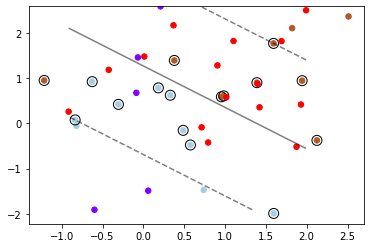

In [16]:
# plot the original training data (x, y) as before but 
# also overlay the test data (purple and red)

xlim = (min (xtest [:, 0]), max (xtest [:, 0]))
ylim = (min (xtest [:, 1]), max (xtest [:, 1]))

axes = Svc2dPlot (x [:, 0], x[:, 1], y, bestmod, xlim, ylim, showPlot=False)
axes.scatter (x = xtest [:, 0], y = xtest [:, 1], c = ytest, s = 30, cmap = pyplot.cm.rainbow)
pyplot.show ()

In [17]:
# fit model with the new cost of 0.01, this will be compressed to single line
svmfit = sklearn.svm.SVC (C = 0.01, kernel="linear").fit (x, y)
ypred = svmfit.predict (X = xtest)

# output the confusion matrix 
print ("Confusion Matrix [cost = 0.01]")
print (sklearn.metrics.confusion_matrix (y_true = ytest, y_pred = ypred))

# output the classification report 
print ("\n" + sklearn.metrics.classification_report (y_true = ytest, y_pred = ypred))


Confusion Matrix [cost = 0.01]
[[4 1]
 [8 7]]

              precision    recall  f1-score   support

          -1       0.33      0.80      0.47         5
           1       0.88      0.47      0.61        15

    accuracy                           0.55        20
   macro avg       0.60      0.63      0.54        20
weighted avg       0.74      0.55      0.57        20



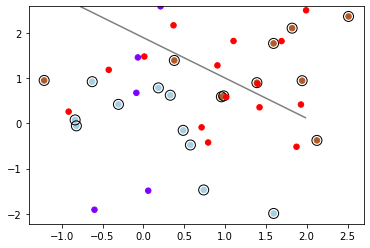

In [18]:
# plot the original training data (x, y) as before but 
# also overlay the test data (purple and red)

xlim = (min (xtest [:, 0]), max (xtest [:, 0]))
ylim = (min (xtest [:, 1]), max (xtest [:, 1]))

axes = Svc2dPlot (x [:, 0], x[:, 1], y, svmfit, xlim, ylim, showPlot=False)
axes.scatter (x = xtest [:, 0], y = xtest [:, 1], c = ytest, s = 30, cmap = pyplot.cm.rainbow)
pyplot.show ()

To demonstrate the impact of the cost parameter on the classifier, we can fit and plot 4 different costs \[0.01, 0.1, 1, 10]. From the plots, it is easy to see that the smaller the costs, the wider the margin needs to be and the larger the costs, the more narrow the margin becomes. 

If a point is outside the margin and correctly classified, it's cost $\epsilon_i$ is 0. 

If a point is inside the margin and correctly classified, it's cost $\epsilon_i$ is (0, 1].

If a point is outside the margin and incorrectly classified, it's cost $\epsilon_i$ is > 1.

To successfully fit a SVC, the following must be true

$$\epsilon_i \geq 0, \sum_{i=1}^n{\epsilon_i} \leq C$$



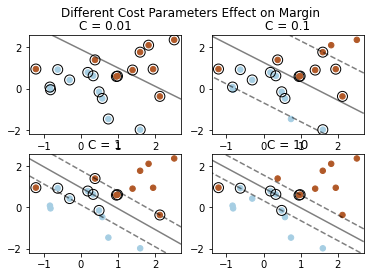

In [19]:
# let's plot all the cost options that we have considered to see them next to each other

figure, axes = pyplot.subplots (2, 2)
figure.size = [6.5, 4.5]
figure.suptitle ("Different Cost Parameters Effect on Margin")

pyplot.sca (axes [0, 0])
axes [0, 0].set_title ("C = 0.01")
plot1 = Svc2dPlot (x [:, 0], x[:, 1], y, sklearn.svm.SVC (C = 0.01, kernel="linear").fit (x, y), showPlot=False)

pyplot.sca (axes [0, 1])
axes [0, 1].set_title ("C = 0.1")
plot2 = Svc2dPlot (x [:, 0], x[:, 1], y, sklearn.svm.SVC (C = 0.1,  kernel="linear").fit (x, y), showPlot=False)

pyplot.sca (axes [1, 0])
axes [1, 0].set_title ("C = 1")
plot3 = Svc2dPlot (x [:, 0], x[:, 1], y, sklearn.svm.SVC (C = 1,    kernel="linear").fit (x, y), showPlot=False)

pyplot.sca (axes [1, 1])
axes [1, 1].set_title ("C = 10")
plot4 = Svc2dPlot (x [:, 0], x[:, 1], y, sklearn.svm.SVC (C = 10,   kernel="linear").fit (x, y), showPlot=False)

# Notice that a smaller cost requires larger margins, and that the margins are off the 
# plot on the first plot. This allows misclassification of points within the margin to be
# less than 1 in cost where misclassification of points outside of the margin are > 1 in cost.

Let's consider a case where the 2 classes are linearly separatable, that we can have a solution with no misclassifications. The below code pushes the classes further apart in the space using the original X matrix and adding another 0.5 to the 1 class. We then fit a classifier with a very large cost.  

R Code
```{R}
# clone the x matrix and further push the classes apart
xtrain = x
xtrain [y == 1, ] = xtrain [y == 1, ] + 0.5
```


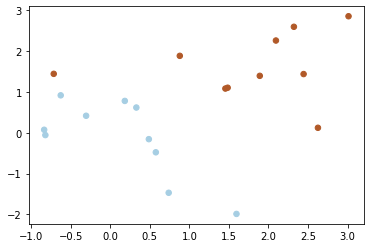

In [20]:
xtrain = x.copy ()
xtrain [numpy.where (y == 1)] = x [numpy.where (y == 1)] + 0.5
ytrain = y.copy ()

# plot the original points and create a referencable plot axes 
pyplot.scatter (x = xtrain [:, 0], y = xtrain [:, 1], c = ytrain, s = 30, cmap = pyplot.cm.Paired)


In [21]:
# fit the new training set
svmfit = sklearn.svm.SVC (C = 100000, kernel="linear").fit (xtrain, ytrain)

# print the summary information of the fit 
SvcSummary (svmfit, xtrain, ytrain)

Call:
SVC(C=100000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Parameters: 
   SVM-Type: C-classification
 SVM-Kernal: linear
       cost: 100000
      gamma: scale
Number of Support Vectors:  3
Counter({1: 2, -1: 1})
Number of Classes:  2
Levels:
[-1  1]
Score:
1.0


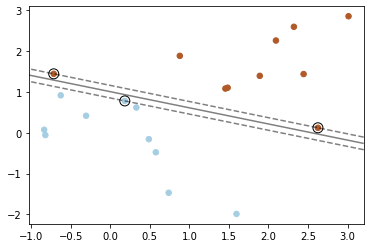

In [22]:
Svc2dPlot (xtrain [:, 0], xtrain[:, 1], ytrain, svmfit)

In [23]:
ypred = svmfit.predict (X = xtest)

print ("Score:")
print (svmfit.score (xtest, ytest))

# output the confusion matrix 
print ("Confusion Matrix [cost = 100000]")
print (sklearn.metrics.confusion_matrix (y_true = ytest, y_pred = ypred))

# output the classification report 
print ("\n" + sklearn.metrics.classification_report (y_true = ytest, y_pred = ypred))

Score:
0.6
Confusion Matrix [cost = 100000]
[[3 2]
 [6 9]]

              precision    recall  f1-score   support

          -1       0.33      0.60      0.43         5
           1       0.82      0.60      0.69        15

    accuracy                           0.60        20
   macro avg       0.58      0.60      0.56        20
weighted avg       0.70      0.60      0.63        20



No training errors were made and only three support vectors were used. However, we can see from the figure that the margin is very narrow (because the observations that are not support vectors, indicated as not circled points, are very close to the decision boundary). It seems likely that this model will perform poorly on test data. 

In [24]:
# fit the new training set
svmfit = sklearn.svm.SVC (C = 1, kernel="linear").fit (xtrain, ytrain)

# print the summary information of the fit 
SvcSummary (svmfit, xtrain, ytrain)

Call:
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Parameters: 
   SVM-Type: C-classification
 SVM-Kernal: linear
       cost: 1
      gamma: scale
Number of Support Vectors:  7
Counter({1: 4, -1: 3})
Number of Classes:  2
Levels:
[-1  1]
Score:
0.95


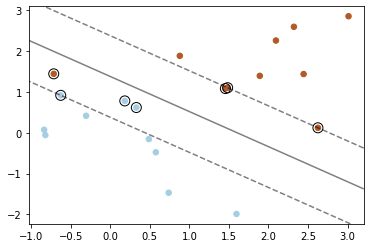

In [25]:
Svc2dPlot (xtrain [:, 0], xtrain[:, 1], y, svmfit)


In [26]:
ypred = svmfit.predict (X = xtest)
print ("Score:")
print (svmfit.score (xtest, ytest))

# output the confusion matrix 
print ("Confusion Matrix [cost = 100000]")
print (sklearn.metrics.confusion_matrix (y_true = ytest, y_pred = ypred))

# output the classification report 
print ("\n" + sklearn.metrics.classification_report (y_true = ytest, y_pred = ypred))

Score:
0.65
Confusion Matrix [cost = 100000]
[[ 3  2]
 [ 5 10]]

              precision    recall  f1-score   support

          -1       0.38      0.60      0.46         5
           1       0.83      0.67      0.74        15

    accuracy                           0.65        20
   macro avg       0.60      0.63      0.60        20
weighted avg       0.72      0.65      0.67        20



Using `C = 1` (`cost = 1`), we misclassify a training observation (the red below the solid line), but we also obtain a much wider margin and make use of seven support vectors. It seems likely that this model will perform better on test data than the model with `cost = 100000`.